In [2]:
import pandas as pd
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

### Batter Segmentation Analysis

In [6]:
pitcher_data = pd.read_csv('data/cleaned/final_pitchers_df.csv')

In [7]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=8, init="k-means++", n_init="auto", random_state=6021))
])

In [8]:
# decide what features to use for clustering (initially remove categorical features where distance metrics don't make sense)
X = pitcher_data.select_dtypes(include=['float64', 'int64'])
X.dtypes

year                    int64
age                     int64
avg_salary_year       float64
free_agent_salary     float64
W                     float64
L                     float64
G                     float64
GS                    float64
CG                    float64
SHO                   float64
SV                    float64
H                     float64
ER                    float64
HR                    float64
BB                    float64
SO                    float64
IBB                   float64
WP                    float64
HBP                   float64
BK                    float64
BFP                   float64
GF                    float64
R                     float64
SH                    float64
SF                    float64
GIDP                  float64
ERA                   float64
BAOpp                 float64
InnOuts               float64
PO                    float64
A                     float64
E                     float64
DP                    float64
PB        

In [ ]:
# remove variables where distance isn't meaningful like year and salary since we want to look at performance for batters (offense stats only)
X = X.drop(columns=['year', 'avg_salary_year', 'free_agent_salary', 'PB', 'WP', 'SB.1', 'CS.1', 'won_cy_young', 'won_mvp', 'won_gold_glove', 'won_silver_slugger', 'all_star', 'PO', 'InnOuts', 'A', 'E', 'ZR'])
X.columns


Index(['age', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO',
       'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'DP'],
      dtype='object')

In [ ]:
# convert counts to rates for better comparison base (PA = plate appearances)
X['PA'] = X['AB'] + X['BB'] + X['HBP'] + X['SF'] + X['SH']
X['AVG'] = X['H'] / X['AB']
X['OBP'] = (X['H'] + X['BB'] + X['HBP']) / X['PA']
X['SLG'] = (X['H'] + X['2B'] + 2*X['3B'] + 3*X['HR']) / X['AB']
X['ISO'] = X['SLG'] - X['AVG']
X.drop(columns=['AB', 'PA', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS',
'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'DP'
], inplace=True)
X.columns


Index(['age', 'AVG', 'OBP', 'SLG', 'ISO'], dtype='object')

We dropped raw counting stats that are heavily affected by playing time, aka PA, and replaced them with rate-based metrics based on plate appearances, so we are comparing stats based on assumption that they have the same number of opportunities to make a play. The variables we have now are:

age - same as before
AVG - batting average, how often hitter gets a base hit
OBP - on base percentage, how often hitter reaches base by any means
SLG - slugging percentage,  how many bases gained per at-bat
ISO - how much of player's production comes from extra base hits like doubles, triples, home runs

In [ ]:
K_values = list(range(1, 11))
wcss = []

for k in K_values:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(X)
    inertia = pipe["kmeans"].inertia_
    wcss.append(inertia)


fig = px.line(
    x=K_values,
    y=wcss,
    markers=True,
    title="Elbow Plot (Pipeline: StandardScaler + KMeans)",
    labels={"x": "Number of Clusters (K)", "y": "WCSS / Inertia"}
)

fig.update_layout(height=500, width=700)
fig.show()

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Wi

k = 4 looks to be optimal based on elbow, look at sihouette score next

In [ ]:
sil_scores = []
K_values_sil = list(range(2, 11))

for k in K_values_sil:
    pipe.set_params(kmeans__n_clusters=k)
    pipe.fit(X)

    labels = pipe["kmeans"].labels_

    sil = silhouette_score(X, labels)

    sil_scores.append(sil)


fig = px.line(
    x=K_values_sil,
    y=sil_scores,
    markers=True,
    title="Silhouette Scores (Pipeline: StandardScaler + KMeans)",
    labels={"x": "Number of Clusters (K)", "y": "Silhouette Score"}
)

fig.update_layout(height=500, width=700)
fig.show()


c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Wi

Looks like 2 clusters is best

In [ ]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=2, init="k-means++", n_init="auto", random_state=6021))
])

pipe.fit(X)
labels = pipe["kmeans"].labels_

c:\Users\wanns\anaconda3\envs\ds6001\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



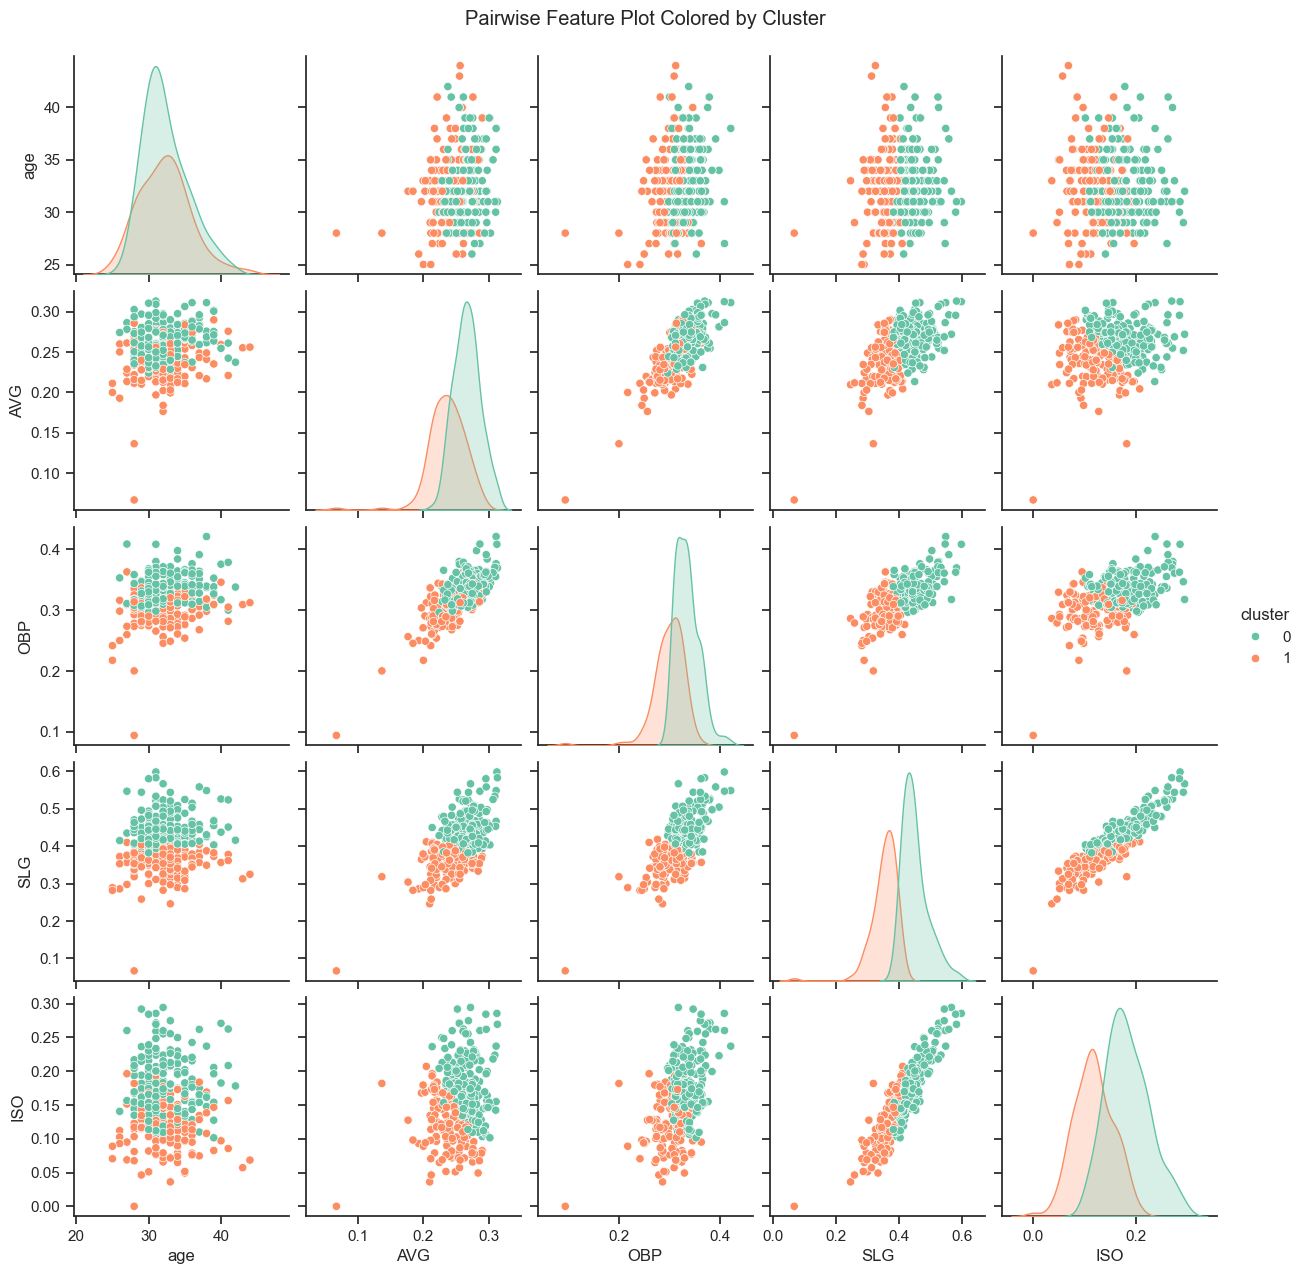

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

X['cluster'] = labels
sns.set(style="ticks", palette="Set2")
sns.pairplot(X, hue="cluster", diag_kind='kde', corner=False)
plt.suptitle("Pairwise Feature Plot Colored by Cluster", y=1.02)
plt.show()

Conclusions:

Age does not really have a big impact at separating performance, whether you are in your 20s or 40s, its not more or less likely to have a higher or lower offensive stat.

Our clusters show a performance gradient, cluster 1 is "weaker" hitters while cluster 0 has "stronger" hitters.

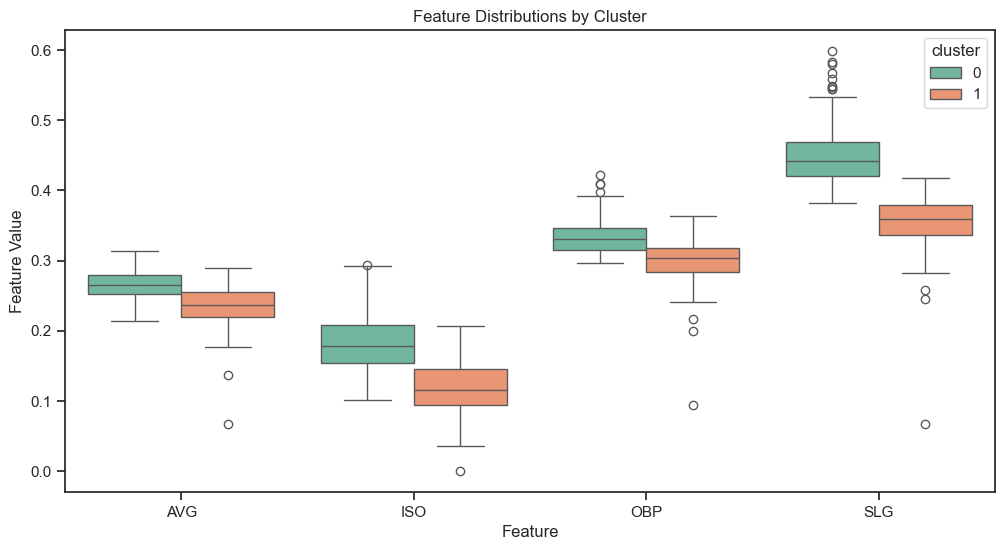

In [ ]:
plot_df = X.melt(id_vars='cluster', value_vars=X.columns.difference(['cluster', 'age']), var_name='Feature', value_name='Value')
plt.figure(figsize=(12,6))
sns.boxplot(x='Feature', y='Value', hue='cluster', data=plot_df, palette='Set2')
plt.title("Feature Distributions by Cluster")
plt.ylabel("Feature Value")
plt.xlabel("Feature")
plt.show()

What separates a good from a bad player in these clusters seems to have more emphasis on SLG and ISO, aka power stats, than plate related stats, but they all seem to contribute important information to distinguish between the clusters.

In [ ]:
cluster_profile = X.groupby('cluster')[['AVG','OBP','SLG','ISO','age']].agg(['mean','median','std'])
cluster_profile


AVG                           OBP                           SLG  \
             mean    median       std      mean    median       std      mean   
cluster                                                                         
0        0.266369  0.265734  0.020032  0.334557  0.331053  0.023363  0.449688   
1        0.236157  0.236970  0.028720  0.298914  0.303096  0.031463  0.353350   

                                  ISO                            age         \
           median       std      mean    median       std       mean median   
cluster                                                                       
0        0.441389  0.041949  0.183319  0.178530  0.041891  32.333333   32.0   
1        0.359812  0.041850  0.117193  0.116001  0.037575  32.250000   32.0   

                   
              std  
cluster            
0        3.142028  
1        3.587530

"Typical" profile of a baseball player in cluster 0 and 1 across all stats used.